<a href="https://www.kaggle.com/code/karan842/500-species-classification-cnn-w-b-92?scriptVersionId=120275347" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bird Species Classification over 500 bird species

### Classifying 500 bird species using CNN architecutre

*In this notebook I am going to build CNN architecture for classifying 500 species of Birds*

- **We will perform some fundmental steps to build CNN model**:

   
   1. Importing libraries: Importing some necessary libraries which are needed for this project
   2. Setting [Weights & Biases](https://wandb.ai/home/) to track the experiemnts 
   3. Loading an image directory and converting them into dataframe with labels as a target species
   4. EDA: Analyzing the target classes and displaying sample set of images.
   5. Data Preprocessing: Performing Data Augmentation, resizing, rescaling 
   6. Building CNN model using Keras Pre-trained models
   7. Tracking the experiments using W&B
   8. Evaluating the model in a detail
  
 
 ## Notebook Extension:
 
 > I am going to create a end to end application either using FastAPI or Streamlit to deploy the model in real world environmet using MLOps. Click about GitHub link to know more

**[GitHub Link](https://github.com/karan842/bird-species-classification/)**

## Experiment Tracking:
> I am tracking model experiments using W&B. Chec it out

**[W&B](https://wandb.ai/karan842/birds-species-classification)**

# Importing libraries

In [20]:
# Classic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from sklearn.model_selection import train_test_split

# tensorflow libaries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import tqdm
import warnings
import glob
import os

# Metrics
from sklearn import metrics
import itertools

# WANDB 
import wandb
wandb.login()

# Noteboook setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Load and transform data

In [21]:
dataset = '/kaggle/input/100-bird-species/train/'

In [22]:
species_types=os.listdir(dataset)
species_types

['DALMATIAN PELICAN',
 'WATTLED CURASSOW',
 'AMERICAN WIGEON',
 'CARMINE BEE-EATER',
 'GAMBELS QUAIL',
 'UMBRELLA BIRD',
 'AMERICAN KESTREL',
 'AMERICAN GOLDFINCH',
 'BLUE GROSBEAK',
 'PALM NUT VULTURE',
 'DUSKY LORY',
 'AUCKLAND SHAQ',
 'BLACK THROATED WARBLER',
 'YELLOW CACIQUE',
 'STRIPPED SWALLOW',
 'VERMILION FLYCATHER',
 'CAPE MAY WARBLER',
 'RED TAILED HAWK',
 'GURNEYS PITTA',
 'INDIAN ROLLER',
 'SNOW GOOSE',
 'GREEN WINGED DOVE',
 'AZURE TANAGER',
 'GREEN MAGPIE',
 'BANDED BROADBILL',
 'AFRICAN PYGMY GOOSE',
 'INDIGO FLYCATCHER',
 'GREY PLOVER',
 'TOUCHAN',
 'HYACINTH MACAW',
 'HARLEQUIN DUCK',
 'ABYSSINIAN GROUND HORNBILL',
 'CALIFORNIA QUAIL',
 'BALD IBIS',
 'WOOD THRUSH',
 'RUBY THROATED HUMMINGBIRD',
 'INDIGO BUNTING',
 'ALBERTS TOWHEE',
 'SORA',
 'HOODED MERGANSER',
 'ROSEATE SPOONBILL',
 'CAPE ROCK THRUSH',
 'BLUE COAU',
 'CALIFORNIA CONDOR',
 'BORNEAN PHEASANT',
 'BARN SWALLOW',
 'TAIWAN MAGPIE',
 'SPLENDID WREN',
 'RED BILLED TROPICBIRD',
 'BLACK THROATED BUSHTIT',
 'CH

## Placing data into a DataFrame

In [23]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

# print(labels)

In [24]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels],axis=1)
image_df

Filepath              Label
0      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
1      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
2      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
3      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
4      /kaggle/input/100-bird-species/train/DALMATIAN...  DALMATIAN PELICAN
...                                                  ...                ...
80080  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80081  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80082  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80083  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE
80084  /kaggle/input/100-bird-species/train/GOLDEN EA...       GOLDEN EAGLE

[80085 rows x 2 columns]

# Exploratory Data Analyis

In [25]:
image_df['Label'].value_counts(ascending=False)

HOUSE FINCH                248
OVENBIRD                   233
D-ARNAUDS BARBET           233
SWINHOES PHEASANT          217
WOOD DUCK                  214
                          ... 
AMETHYST WOODSTAR          131
MASKED LAPWING             131
PATAGONIAN SIERRA FINCH    130
RED TAILED THRUSH          130
SNOWY PLOVER               130
Name: Label, Length: 500, dtype: int64

- Count of each class is ranging between 248 to 130

## Top 200 most occured Bird Species

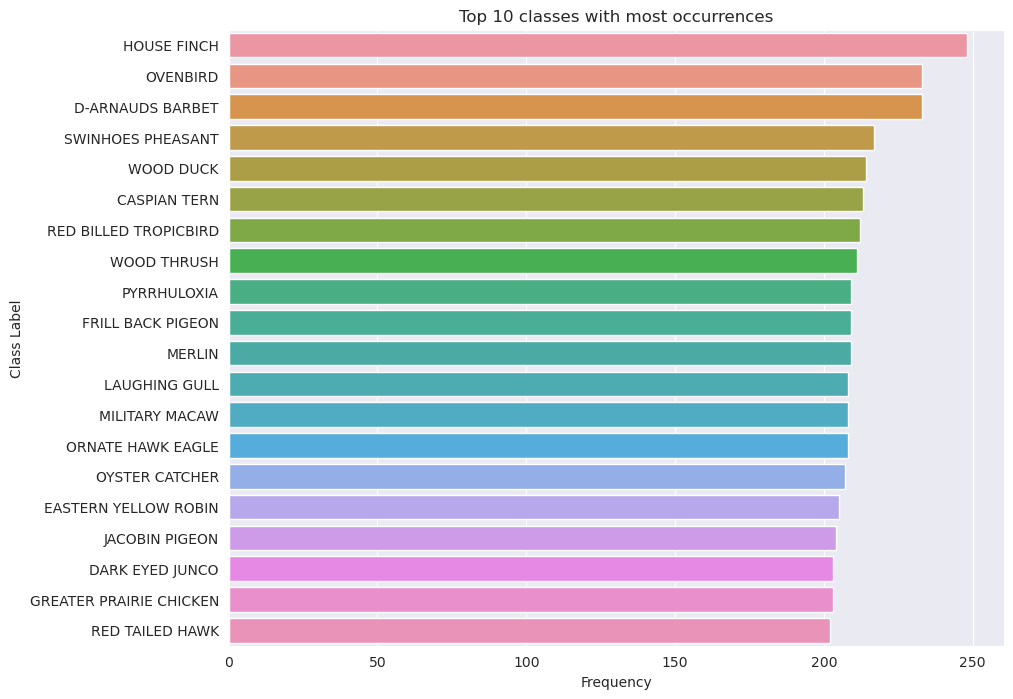

In [26]:
class_freq = {}
class_labels = image_df['Label']
for label in class_labels:
    if label in class_freq:
        class_freq[label] +=1
    else:
        class_freq[label] = 1
        
# sort the classes by frequency in descending order
sorted_class = sorted(class_freq.items(),key=lambda x: x[1],reverse=True)
# print(sorted_class)
top_classes = dict(sorted_class[:20])

plt.figure(figsize=(10,8))
sns.countplot(y=class_labels, order=top_classes.keys())
plt.xlabel("Frequency")
plt.ylabel("Class Label")
plt.title("Top 10 classes with most occurrences")
plt.show();

## Common bird species such as Eagle, Pigeon, Chicken, etc

In [27]:
# Function to fing different types of spcies of some common birds
def diff_species_common(specie,df):
    bird_species = df[df['Label'].str.contains(specie,case=False)]['Label']
    bird_species = bird_species.unique()
    return bird_species

print("Different types of species for an Eagle: \n")
print(diff_species_common('EAGLE', image_df))
print("\n\nDifferent types of species for a Pigeon: \n")
print(diff_species_common('PIGEON',image_df))
print("\n\nDifferent types of species for a Chicken: \n")
print(diff_species_common('CHICKEN',image_df))
print("\n\nDifferent types of species for a Duck: \n")
print(diff_species_common('DUCK',image_df))
print("\n\nDifferent types of species for a Vulture: \n")
print(diff_species_common('SPARROW',image_df))
print("\n\nDifferent types of species for an Owl: \n")
print(diff_species_common('OWL',image_df))
print("\n\nDifferent types of species for a Raven: \n")
print(diff_species_common('RAVEN',image_df))
print("\n\nDifferent types of species for a Sparrow: \n")
print(diff_species_common('SPARROW',image_df))

Different types of species for an Eagle: 

['PHILIPPINE EAGLE' 'BALD EAGLE' 'HARPY EAGLE' 'ORNATE HAWK EAGLE'
 'GREY HEADED FISH EAGLE' 'CRESTED SERPENT EAGLE' 'GOLDEN EAGLE']


Different types of species for a Pigeon: 

['NICOBAR PIGEON' 'CROWNED PIGEON' 'FRILL BACK PIGEON'
 'VICTORIA CROWNED PIGEON' 'JACOBIN PIGEON']


Different types of species for a Chicken: 

['GREATER PRAIRIE CHICKEN']


Different types of species for a Duck: 

['HARLEQUIN DUCK' 'MALLARD DUCK' 'STEAMER DUCK' 'SPOTTED WHISTLING DUCK'
 'MANDRIN DUCK' 'RED HEADED DUCK' 'TEAL DUCK' 'WOOD DUCK']


Different types of species for a Vulture: 

['CHIPPING SPARROW' 'HOUSE SPARROW' 'BLACK-THROATED SPARROW'
 'JAVA SPARROW']


Different types of species for an Owl: 

['GUINEAFOWL' 'ORIENTAL BAY OWL' 'VULTURINE GUINEAFOWL' 'BARN OWL'
 'STRIPED OWL' 'LONG-EARED OWL' 'GREAT GRAY OWL' 'EASTERN MEADOWLARK'
 'SNOWY OWL']


Different types of species for a Raven: 

['WHITE NECKED RAVEN']


Different types of species for a Sparrow: 


## Visualizing sample images from dataset

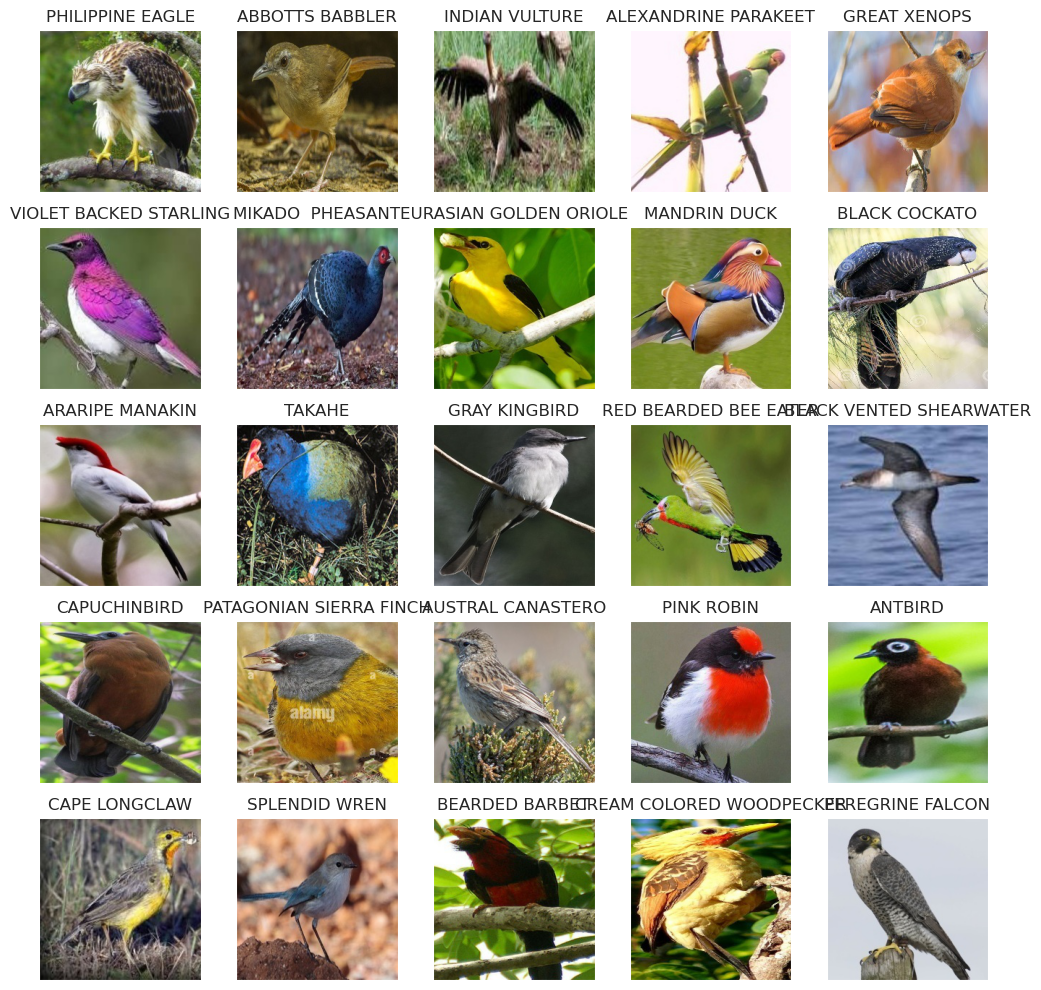

In [28]:
random_index = np.random.randint(0,len(image_df),25)
fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show();

## Data Preprocssing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [29]:
# Seperate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2,
                                     shuffle=True,random_state=42)

### Data Augmentation 

In [30]:
# train_gen = ImageDataGenerator(
#     rotation_range = 15,
#     width_shift_range = 0.05,
#     height_shift_range = 0.05,
#     rescale = 1./255,
#     shear_range = 0.05,
#     brightness_range = [0.1,1.5],
#     horizontal_flip = True,
#     vertical_flip = True
# )

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [31]:
# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 51255 validated image filenames belonging to 500 classes.
Found 12813 validated image filenames belonging to 500 classes.
Found 16017 validated image filenames belonging to 500 classes.


In [32]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

## Training the model

In [33]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

In [34]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(500,activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

## Weights and Biases configuration

In [35]:
# Run 
from wandb.keras import WandbCallback
run = wandb.init(project='birds-species-classification',
                config={ # include hyperparameters and metadata
                    "learning_rate":0.0001,
                    "epochs":100,
                    "batch_size":32,
                    "es_patience":8,
                    "loss_function":"categorical_crossentropy",
                    
                })
config = wandb.config # we will use this to configure our experiment
tf.keras.backend.clear_session()

# model callbacks, optimizers and compilation

## Optimizer
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=config.es_patience,
                              restore_best_weights=True)
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Model compile
model.compile(optimizer,config.loss_function,metrics=['accuracy'])

In [36]:
history = model.fit(
    train_images, 
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=config.epochs,
    callbacks=[
        early_stopping,
        WandbCallback(),
        checkpoint_callback,
    ]
)

Epoch 1/100
1602/1602 [==============================] - 192s 118ms/step - loss: 4.6587 - accuracy: 0.1315 - val_loss: 2.5706 - val_accuracy: 0.4876 - _timestamp: 1677316631.0000 - _runtime: 212.0000
Epoch 2/100
1602/1602 [==============================] - 175s 109ms/step - loss: 2.5554 - accuracy: 0.3916 - val_loss: 1.6435 - val_accuracy: 0.6542 - _timestamp: 1677316806.0000 - _runtime: 387.0000
Epoch 3/100
1602/1602 [==============================] - 177s 111ms/step - loss: 1.9225 - accuracy: 0.5162 - val_loss: 1.3021 - val_accuracy: 0.7048 - _timestamp: 1677316984.0000 - _runtime: 565.0000
Epoch 4/100
1602/1602 [==============================] - 172s 107ms/step - loss: 1.5765 - accuracy: 0.5950 - val_loss: 1.1114 - val_accuracy: 0.7370 - _timestamp: 1677317156.0000 - _runtime: 737.0000
Epoch 5/100
1602/1602 [==============================] - 174s 109ms/step - loss: 1.3609 - accuracy: 0.6452 - val_loss: 0.9834 - val_accuracy: 0.7611 - _timestamp: 1677317360.0000 - _runtime: 941.0000


# Model Evaluation

In [37]:
results = model.evaluate(test_images)
print("    Test Loss: {:.5f}%".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

501/501 [==============================] - 107s 214ms/step - loss: 0.6049 - accuracy: 0.8411
    Test Loss: 0.60492%
Test Accuracy: 84.11%


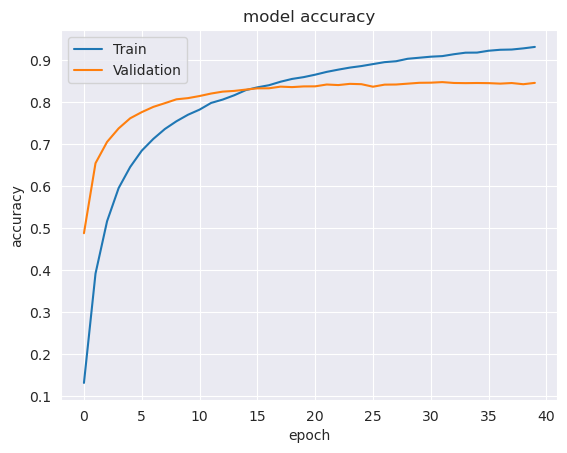

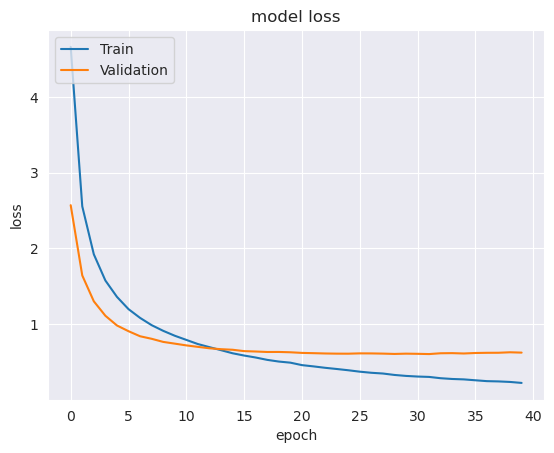

In [38]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

## Making predictiong on the test data

Predict the label of test_images

In [39]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
pred

501/501 [==============================] - 43s 84ms/step


array([233, 258,  19, ..., 283, 139, 433])

In [40]:
# train_images.class_indices

Map the label

In [41]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Result
print(f'First 5 predictions: {pred[:5]}')

First 5 predictions: ['GOLDEN CHLOROPHONIA', 'GREY HEADED FISH EAGLE', 'AMERICAN KESTREL', 'POMARINE JAEGER', 'CAMPO FLICKER']


### Display 25 Random images from dataset with their labels and predict with the model

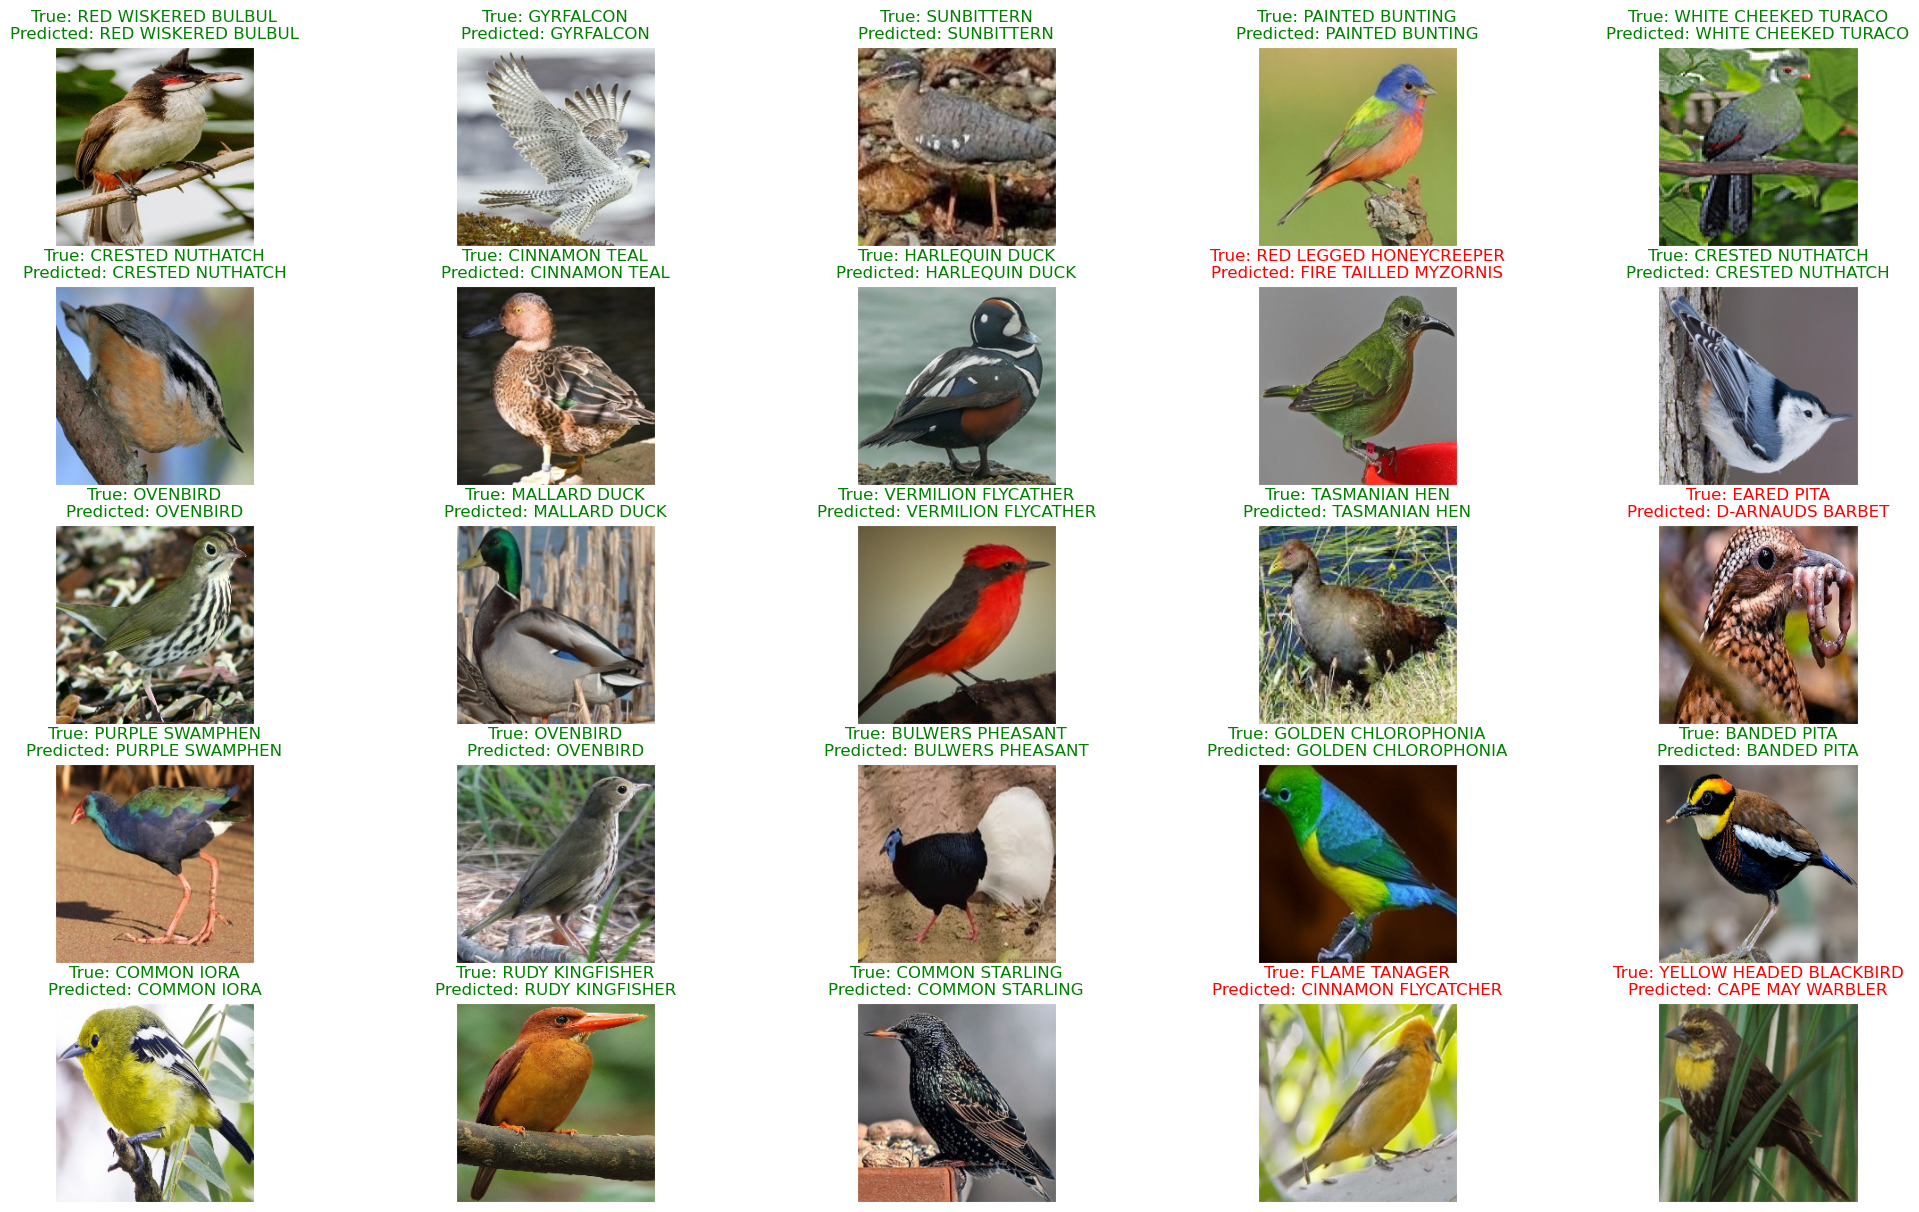

<Figure size 640x480 with 0 Axes>

In [42]:
random_index = np.random.randint(0,len(test_df)-1,25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(25,15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}",
                color=color)

plt.show()
plt.tight_layout()

## Classification Report
We will convert our classification report into dataframe and find the best and worst classes using pandas operations for ease.

In [43]:
species = test_images.class_indices

In [44]:
y_test = list(test_df.Label)
report = metrics.classification_report(y_test, pred,target_names=species,output_dict=True)

data = []
for k,v in report.items():
    if k in species:
        data.append({'species':k,
                    'precision': v['precision'],
                    'recall': v['recall'],
                    'f1-score': v['f1-score'],
                    'support': v['support']})
df = pd.DataFrame(data)
df

species  precision    recall  f1-score  support
0                ABBOTTS BABBLER   0.655172  0.612903  0.633333       31
1                  ABBOTTS BOOBY   0.652174  0.441176  0.526316       34
2     ABYSSINIAN GROUND HORNBILL   0.969697  0.842105  0.901408       38
3          AFRICAN CROWNED CRANE   1.000000  1.000000  1.000000       18
4         AFRICAN EMERALD CUCKOO   0.793103  0.696970  0.741935       33
..                           ...        ...       ...       ...      ...
495                  WOOD THRUSH   0.810811  0.857143  0.833333       35
496                      WRENTIT   0.756098  0.794872  0.775000       39
497  YELLOW BELLIED FLOWERPECKER   0.888889  0.666667  0.761905       36
498               YELLOW CACIQUE   0.720000  0.750000  0.734694       24
499      YELLOW HEADED BLACKBIRD   0.928571  0.812500  0.866667       32

[500 rows x 5 columns]

In [45]:
def best_classes(df):
    print("Classed with good result: ")
    top_10_good = df.nlargest(10,'f1-score')
    res = top_10_good[['species','precision','recall','f1-score','support']]
    return res
    
best_classes(df)

Classed with good result: 


species  precision    recall  f1-score  support
3    AFRICAN CROWNED CRANE   1.000000  1.000000  1.000000       18
321           LOONEY BIRDS   1.000000  1.000000  1.000000       33
341         NICOBAR PIGEON   1.000000  1.000000  1.000000       32
139       CHUKAR PARTRIDGE   0.975610  1.000000  0.987654       40
60                BARN OWL   1.000000  0.973684  0.986667       38
17       AMERICAN FLAMINGO   0.970588  1.000000  0.985075       33
174             CUBAN TODY   0.970588  1.000000  0.985075       33
417        RUDY KINGFISHER   0.969697  1.000000  0.984615       32
277                HOOPOES   1.000000  0.968750  0.984127       32
329           MANDRIN DUCK   0.967742  1.000000  0.983607       30

In [46]:
def worst_classes(df):
    print("Classed with bad result: ")
    top_10_bad = df.nsmallest(10,'f1-score')
    res = top_10_bad[['species','precision','recall','f1-score','support']]
    return res
    
worst_classes(df)

Classed with bad result: 


species  precision    recall  f1-score  support
227          GILDED FLICKER   0.312500  0.588235  0.408163       17
345        NORTHERN FLICKER   0.529412  0.375000  0.439024       24
31                  ANTBIRD   0.526316  0.400000  0.454545       25
249            GREAT XENOPS   0.518519  0.437500  0.474576       32
348        NORTHERN GOSHAWK   0.625000  0.405405  0.491803       37
258  GREY HEADED FISH EAGLE   0.533333  0.470588  0.500000       17
464    TRICOLORED BLACKBIRD   0.650000  0.419355  0.509804       31
333            MASKED BOOBY   0.478261  0.550000  0.511628       20
1             ABBOTTS BOOBY   0.652174  0.441176  0.526316       34
188             DUSKY ROBIN   0.550000  0.550000  0.550000       20

In [60]:
wandb.finish()

# Saving best model

In [62]:
api = wandb.Api()

runs = api.runs("karan842/birds-species-classification")

In [67]:
# Get the best run based on the validation accuracy
best_run = None
best_val_acc = 0

for run in runs:
    if run.state != "finished":
        continue
    if "val_accuracy" not in run.summary:
        continue
    val_acc = run.summary["val_accuracy"]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_run = run

# Print the best run ID and validation accuracy
if best_run is not None:
    print("Best run: ", best_run.name)
    print("Validation accuracy: ", best_val_acc)
else:
    print("No runs found.")

Best run:  fast-water-72
Validation accuracy:  0.8453133702278137


In [68]:
# Get the best run based on the accuracy
best_run2 = None
best_acc = 0

for run in runs:
    if run.state != "finished":
        continue
    if "val_accuracy" not in run.summary:
        continue
    val_acc = run.summary["accuracy"]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_run2 = run

# Print the best run ID and validation accuracy
if best_run is not None:
    print("Best run: ", best_run2.name)
    print("Accuracy: ", best_acc)
else:
    print("No runs found.")

Best run:  fast-water-72
Accuracy:  0


### Current model has best val_accuracy score
- Saving the model in .h5 format

In [65]:
model.save('best_model.h5')
print('Model Saved!!')

Model Saved!!


# Predictions!!

In [73]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')

In [78]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def predict_image_class(model, img_path):
    # Load and preprocess the input image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make a prediction using the model
    preds = model.predict(x)

    # Get the top 5 predicted classes and their probabilities
    top_preds = np.argsort(-preds)[0][:5]
    top_probs = preds[0][top_preds]
    
    # Print the top 5 predicted classes and their probabilities
    print("\nTop 5 predicted classes and their probabilities:")
    for i in range(len(top_preds)):
        print("{:2d}. {}: {:.2f}%".format(i+1, species_types[top_preds[i]], 100*top_probs[i]))

## Predicting image class baed on input image

In [80]:
img = '/kaggle/input/100-bird-species/train/BALD IBIS/002.jpg'
predict_image_class(model,img)

1/1 [==============================] - 0s 22ms/step

Top 5 predicted classes and their probabilities:
 1. BARRED PUFFBIRD: 55.86%
 2. RED HEADED WOODPECKER: 19.17%
 3. GILDED FLICKER: 13.74%
 4. COMMON STARLING: 9.30%
 5. OYSTER CATCHER: 0.29%


- In future we can increase the model performance. This was just a practice.

# End Notes:

## Give an upvote to a kernel also try to check Github repository given above